# 多層パーセプトロンによるMNISTクラス分類

In [1]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import numpy as np
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (9, 6) # グラフの表示サイズを変更

In [2]:
sys.version_info

sys.version_info(major=2, minor=7, micro=13, releaselevel='final', serial=0)

## Chainerのロード

In [3]:
import chainer
from chainer import Variable, Function, Link, optimizers
import chainer.functions as F
import chainer.links as L

In [4]:
chainer.__version__

'1.21.0'

## MNISTデータをロード

In [5]:
def load_dataset():
    dataset = scipy.io.loadmat('./ex4data1.mat')
    xs = dataset['X'].tolist()
    ys = dataset['y'].ravel().tolist()

    # 元のラベルデータは0のラベルが'10'なので、'0'に置き換え直す
    ys = np.asarray([0 if y == 10 else y for y in ys]).reshape(len(ys))
    # 画像データを (5000, 20, 20) に置き換え直す
    xs = np.asarray([np.asarray(x).reshape(20,20).T for x in xs]).reshape(len(ys), 20, 20).astype(np.float32)
    return xs, ys


xs, ys = load_dataset()

print (xs.shape, ys.shape)
print (type(xs[0][0][0]), type(ys[0]))

(5000, 20, 20) (5000,)
<type 'numpy.float32'> <type 'numpy.int64'>


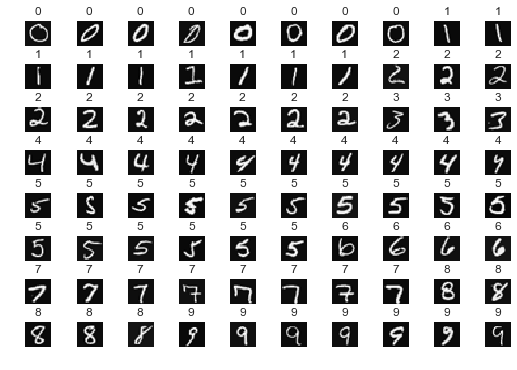

In [6]:
def display_images(images, labels):
    m = len(labels)
    rows = int(math.floor(math.sqrt(m)))
    columns = int(math.ceil(m / rows))

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.7)

    for row in range(rows):
        for col in range(columns):
            index = row * columns + col
            ax = fig.add_subplot(rows, columns, index+1)
            ax.axis('off')
            ax.set_title(labels[index])
            ax.imshow(images[index], cmap=plt.get_cmap('gray'))

# ランダムに抽出した画像とラベルを表示する
rand_ixs = sorted(np.random.randint(0, ys.shape[0], 80))
rand_xs = xs[rand_ixs, :]
rand_ys = ys[rand_ixs]

display_images(rand_xs, rand_ys)

## ネットワークを定義

In [17]:
class MLP(chainer.Chain):
    def __init__(self, n_in, n_mid, n_out):
        super(MLP, self).__init__(
            fc_in  = L.Linear(n_in, n_mid),
            fc_mid = L.Linear(n_mid, n_mid),
            fc_out = L.Linear(n_mid, n_out)
        )
        self.train = True

    def __call__(self, x, y):
        h = F.sigmoid(self.fc_in(x))
        h = F.sigmoid(self.fc_mid(h))
        h = self.fc_out(h)
        
        self.loss = F.softmax_cross_entropy(h, y)
        self.accuracy = F.accuracy(h, y)
        
        if self.train:
            return self.loss
        else:
            return F.softmax(h)

## モデル学習

### 学習データを分割
- 80%を訓練用、20%をクロスバリデーション用に分割

In [7]:
def devide_dataset(xs, ys):
    train_ixs = sorted(random.sample(range(ys.shape[0]), int(ys.shape[0] * 0.8)))
    test_ixs = sorted(list(set(range(ys.shape[0])) - set(train_ixs)))
    return xs[train_ixs, :], ys[train_ixs], xs[test_ixs, :], ys[test_ixs]

train_xs, train_ys, test_xs, test_ys = devide_dataset(xs, ys)
train_xs.shape, train_ys.shape, test_xs.shape, test_ys.shape

# display_images(test_xs, test_ys)

((4000, 20, 20), (4000,), (1000, 20, 20), (1000,))

### モデルの生成と学習手法の設定

In [25]:
n_in = xs[0].shape[0] * xs[0].shape[1]
n_mid = 25
n_out = len(np.unique(ys))

model = MLP(n_in, n_mid, n_out)  # (400, 25, 10)
optimizer = optimizers.SGD(lr=1.0)
optimizer.setup(model)

### 学習処理を実行
- コードをシンプルにするためにバッチ学習を使う

In [26]:
def one_epoch(model, optimizer, xs, ys):
    # クロスエントロピーで評価する場合は
    # ラベルデータを1-of-K notationに変換する必要はない
    # MSEで評価する場合は必要かも
    volatile = 'off' if model.train else 'on'
    x = Variable(np.asarray(xs).astype(np.float32), volatile=volatile)
    y = Variable(np.asarray(ys).astype(np.int32), volatile=volatile)
    
    if model.train:
        optimizer.update(model, x, y)
        return model.loss
    else:
        return model(x, y)

    
n_iter = 300
learning_curve = []

for count in range(1, n_iter+1):
    model.train = True
    one_epoch(model, optimizer, train_xs, train_ys)
    train_loss = model.loss.data
    train_acc  = model.accuracy.data
    
    model.train = False
    one_epoch(model, optimizer, test_xs, test_ys)
    test_loss = model.loss.data
    test_acc  = model.accuracy.data
    
    sys.stdout.write('\rlearning : {0} {1} {2} {3} {4} ...'.format(count, train_loss, train_acc, test_loss, test_acc))
    sys.stdout.flush()
    learning_curve.append(
        {'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc}
    )

learning : 300 0.352528214455 0.909250020981 0.408108919859 0.885999977589 ...

## 学習曲線をプロット

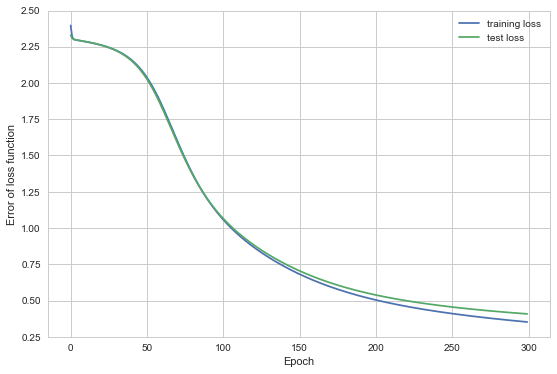

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot([c['train_loss'] for c in learning_curve], label='training loss')
ax.plot([c['test_loss'] for c in learning_curve], label='test loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Error of loss function')

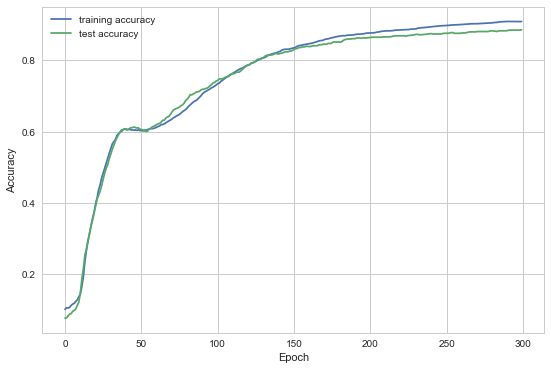

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot([c['train_acc'] for c in learning_curve], label='training accuracy')
ax.plot([c['test_acc'] for c in learning_curve], label='test accuracy')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')

## Trainerを使った学習
- Chainer version 1.11.0 より追加
- 学習ループや結果の表示をより短く実装できる

In [15]:
from chainer import training
from chainer.training import extensions
from chainer.datasets import tuple_dataset

/Users/uents/.anyenv/envs/pyenv/versions/anaconda2-4.3.0/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [16]:
model = MLP(n_in, n_mid, n_out)  # (400, 25, 10)
optimizer = chainer.optimizers.SGD(lr=1.0)
optimizer.setup(model)

In [20]:
train = tuple_dataset.TupleDataset(train_xs.astype(np.float32), train_ys.astype(np.int32))
test = tuple_dataset.TupleDataset(test_xs.astype(np.float32), test_ys.astype(np.int32))

train_iter = chainer.iterators.SerialIterator(train, 100)
test_iter = chainer.iterators.SerialIterator(test, 100, repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=-1)
trainer = training.Trainer(updater, (50, 'epoch'), out="result")

trainer.extend(extensions.Evaluator(test_iter, model, device=-1))
#trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.snapshot(), trigger=(10, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
     'main/accuracy', 'validation/main/accuracy']))
trainer.extend(extensions.ProgressBar())
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy
1                                                                                      
2                                                                                      
     total [##................................................]  5.00%
this epoch [#########################.........................] 50.00%
       100 iter, 2 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
3                                                                                      
4                                                                                      
5                                                                                      
     total [#####.............................................] 10.00%
this epoch [..................................................]  0.00%
       200 iter, 5 epoch / 50 epochs
    277.64 iters/sec. Estimated time to finish: 0:00:06.483